In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import os
import json
import sys
import numpy as np
sys.path.append("..")
import copy
from tqdm.auto import tqdm

In [3]:
from src import models, data, operators, utils, functional, metrics, lens
from src.utils import logging_utils, experiment_utils
import logging
import torch
import baukit

experiment_utils.set_seed(123456)

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.INFO,
    format = logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout
)

In [4]:
from scripts.interpolation import save_order_1_approx, normalize_on_sphere

2023-08-09 19:00:20 src.utils.experiment_utils INFO     setting all seeds to 123456


### Rough -- Caching Jacobians

In [5]:
relation = data.load_dataset().filter(relation_names=["country capital city"])[0].set(prompt_templates=[" {}:"])
train, test = relation.split(5)

#################################################
h_layer = 8
beta = 2.25
interpolation_steps = 100
#################################################

mt = models.load_model(name = "gptj", fp16 = True, device = "cuda")

2023-08-09 19:00:21 src.models INFO     loading EleutherAI/gpt-j-6B (device=cuda, fp16=True)
2023-08-09 19:00:30 src.models INFO     dtype: torch.float16, device: cuda:0, memory: 12219206136


In [6]:
icl_prompt = functional.make_prompt(
    prompt_template = train.prompt_templates[0],
    subject = "{}",
    examples = train.samples,
    mt = mt
)
print(icl_prompt)

test = functional.filter_relation_samples_based_on_provided_fewshots(
    mt = mt, 
    test_relation=test,
    prompt_template = icl_prompt,
    batch_size=4
)
len(test.samples)

<|endoftext|> Pakistan: Islamabad
 Argentina: Buenos Aires
 Peru: Lima
 Australia: Canberra
 Germany: Berlin
 {}:


18

In [7]:
s1, s2 = "France", "Italy"

functional.predict_next_token(
    mt = mt,
    prompt=[icl_prompt.format(s1), icl_prompt.format(s2)],
)

[[PredictedToken(token=' Paris', prob=0.9265950918197632),
  PredictedToken(token=' Lyon', prob=0.013743681833148003),
  PredictedToken(token=' Stras', prob=0.009084018878638744),
  PredictedToken(token=' T', prob=0.005596501287072897),
  PredictedToken(token=' B', prob=0.0033680337946861982)],
 [PredictedToken(token=' Rome', prob=0.8333140015602112),
  PredictedToken(token=' Milan', prob=0.08123007416725159),
  PredictedToken(token=' Florence', prob=0.01676277257502079),
  PredictedToken(token=' Tur', prob=0.015262679196894169),
  PredictedToken(token=' Pal', prob=0.009403063915669918)]]

In [8]:
hs_and_zs = functional.compute_hs_and_zs(
    mt = mt,
    prompt_template = train.prompt_templates[0],
    subjects = list(set([sample.subject for sample in relation.samples] + [s1, s2])),
    h_layer= h_layer,
    z_layer=-1,
    examples= train.samples
)
h1, h2 = [hs_and_zs.h_by_subj[s] for s in [s1, s2]]
z1, z2 = [hs_and_zs.z_by_subj[s] for s in [s1, s2]]

In [9]:
# H = []
# for alpha in np.linspace(0, 1, interpolation_steps):
#     H.append(h1 * (1-alpha) + h2 * alpha)
# H = torch.stack(H)
# torch.dist(h1, H[-1])

In [10]:
# h_index, inputs = functional.find_subject_token_index(
#     mt=mt, prompt=icl_prompt.format(s1), subject=s1
# )

In [11]:
# for idx, h in tqdm(enumerate(H)):
#     approx = functional.order_1_approx(
#         mt = mt,
#         prompt = icl_prompt.format(s1),
#         h_layer = h_layer,
#         h_index= h_index,
#         h = h
#     )
#     save_order_1_approx(approx, file_name = f"approx_{idx+1}")
#     w_norm = approx.weight.norm()
#     b_norm = approx.bias.norm()
#     jh_norm = approx.metadata['Jh'].norm()
#     top_predictions, _ = lens.logit_lens(mt, approx.z, get_proba=True, k=3)
#     print(f"{idx+1} => {w_norm=:.2f} | {b_norm=:.2f} | {jh_norm=:.2f} | {top_predictions=}")

In [12]:
u = (h2 - h1) / (h2 - h1).norm()
v = (z2 - z1) / (z2 - z1).norm()

u = u.float()
v = v.float()

h1 = h1.float()
h2 = h2.float()
z1 = z1.float()
z2 = z2.float()

type(u), type(v)

(torch.Tensor, torch.Tensor)

In [13]:
def load_cached_values(trial_path, idx):
    approx = np.load(f"{trial_path}/approx_{idx+1}.npz", allow_pickle=True)
    approx_dict = {}
    for key,value in approx.items():
        if key in ["h", "z", "weight", "bias"]:
            approx_dict[key] = torch.from_numpy(value).cuda()
        else:
            approx_dict[key] = value
    
    weight = torch.Tensor(approx['weight']).cuda()
    h = torch.Tensor(approx['h']).cuda()
    z = torch.Tensor(approx['z']).cuda()

    return weight, h, z

In [39]:
path = "../results/interpolation/country capital city/"
trials = os.listdir(path)

J_means, H_means, Z_means = [], [], []

for idx in tqdm(range(interpolation_steps)):
    J_idx, h_idx, z_idx = [], [], []
    for trial in ["France-Italy"]: #trials:
        j, h, z  = load_cached_values(os.path.join(path, trial), idx)
        J_idx.append(j)
        h_idx.append(h)
        z_idx.append(z)

    print(len(J_idx), len(h_idx), len(z_idx))

    J_idx = torch.stack(J_idx).mean(dim = 0)
    h_idx = torch.stack(h_idx).mean(dim = 0)
    z_idx = torch.stack(z_idx).mean(dim = 0)

    J_means.append(J_idx)
    H_means.append(h_idx)
    Z_means.append(z_idx)

  0%|          | 0/100 [00:00<?, ?it/s]

1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1


In [54]:
from src.operators import JacobianIclMeanEstimator

estimator = JacobianIclMeanEstimator(mt = mt, h_layer=h_layer)
train, test = relation.split(train_size=5)
operator = estimator(train)

In [55]:
W = operator.weight.float()
W.norm()

tensor(23.9000, device='cuda:0')

In [62]:
ratio_info = []

h_dest = H_means[-1]
z_dest = Z_means[-1]
for idx in range(interpolation_steps):
    h_from = H_means[idx]
    z_from = Z_means[idx]
    u = (h_dest - h_from)
    u /= u.norm()
    v = (z_dest - z_from)
    v /= v.norm()

    W = J_means[idx]
    denominator = u.T @ W @ (v * (h_dest - h_from).norm())

    nominator = 0
    # ds = (h_dest - h_from)/(interpolation_steps - idx)
    for jdx in range(idx+1, interpolation_steps-1):
        dF = J_means[jdx]
        nominator += u.T @ dF @ (H_means[jdx+1] - H_means[jdx])
    
    print(f"{idx} ==>{nominator.item()} / {denominator.item()}")

    ratio = nominator / denominator
    ratio_info.append(ratio.item())

0 ==>10.492744445800781 / 0.4916874170303345
1 ==>10.488081932067871 / 0.4890976548194885
2 ==>10.47272777557373 / 0.4862172603607178
3 ==>10.471304893493652 / 0.4869230091571808
4 ==>10.46075439453125 / 0.48519694805145264
5 ==>10.446447372436523 / 0.4837374687194824
6 ==>10.43923282623291 / 0.4836711585521698
7 ==>10.421395301818848 / 0.48488932847976685
8 ==>10.41196346282959 / 0.4875834584236145
9 ==>10.391966819763184 / 0.48913487792015076
10 ==>10.381738662719727 / 0.48870760202407837
11 ==>10.373917579650879 / 0.4906885623931885
12 ==>10.354934692382812 / 0.4915838837623596
13 ==>10.33588981628418 / 0.49679648876190186
14 ==>10.312155723571777 / 0.4992642104625702
15 ==>10.298731803894043 / 0.5026156902313232
16 ==>10.273240089416504 / 0.5085893273353577
17 ==>10.249100685119629 / 0.5135785341262817
18 ==>10.232484817504883 / 0.5191711187362671
19 ==>10.205108642578125 / 0.5268051624298096
20 ==>10.173453330993652 / 0.5362954139709473
21 ==>10.14499282836914 / 0.5471371412277222

AttributeError: 'int' object has no attribute 'item'

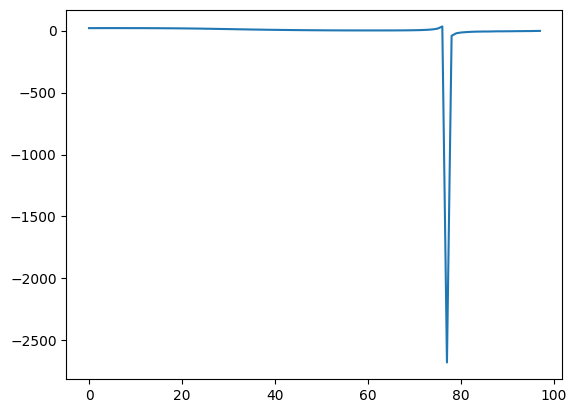

In [61]:
plt.plot(ratio_info)
# plt.ylim(-5, 500)

### Loading Cached $\mathcal{W}$ and $b$

In [140]:
path = "../results/interpolation/country capital city/"
W_norms = []
B_norms = []
Jh_norms = []
J_delta_h = []

values = []
labels = []


for trial in os.listdir(path):
    # if(trial == "Colombia-Venezuela"):
    #     continue
    if(trial != f"{s1}-{s2}"):
        continue

    s1, s2 = trial.split("-")
    hs_and_zs = functional.compute_hs_and_zs(
        mt = mt,
        prompt_template = train.prompt_templates[0],
        subjects = list(set([sample.subject for sample in relation.samples] + [s1, s2])),
        h_layer= h_layer,
        z_layer=-1,
        examples= train.samples
    )
    h1, h2 = [hs_and_zs.h_by_subj[s] for s in [s1, s2]]
    z1, z2 = [hs_and_zs.z_by_subj[s] for s in [s1, s2]]

    do = (z2 - z1).float()
    ds = (h2 - h1).float()

    trial_path = os.path.join(path, trial)
    approxes = []
    interpolation_steps = len(os.listdir(trial_path))
    for idx in tqdm(range(interpolation_steps)):
        approx = np.load(f"{trial_path}/approx_{idx+1}.npz", allow_pickle=True)
        approx_dict = {}
        for key,value in approx.items():
            if key in ["h", "z", "weight", "bias"]:
                approx_dict[key] = torch.from_numpy(value).cuda()
            else:
                approx_dict[key] = value
        approxes.append(approx_dict)

    for a in approxes:
        weight = torch.Tensor(a['weight']).float().cuda()

        # scalar_value = torch.cosine_similarity(weight @ ds, do, dim = -1)
        # scalar_value = torch.dot(weight @ ds, do)
        # G = torch.tensor([torch.dot(do, weight[i]) for i in range(models.determine_hidden_size(mt))]).cuda()
        # scalar_value = torch.dot(G, ds)
        scalar_value = do[None] @ (weight @ ds[None].T)
        values.append(scalar_value.item())



    # w_norms = [torch.Tensor(a['weight']).norm().item() for a in approxes]
    # b_norms = [torch.Tensor(a['bias']).norm().item() for a in approxes]
    # jh_norms = [torch.Tensor(a["metadata"].item()["Jh"]).norm().item() for a in approxes]

    # h1 = normalize_on_sphere(approxes[0]['h'], scale=60.0)
    # h2 = normalize_on_sphere(approxes[-1]['h'], scale=60.0)
    # delta_h = normalize_on_sphere(h2 - h1, scale=60.0)
    # # delta_h = hs_and_zs.h_by_subj["Russia"]
    # j_delta_h = [(torch.Tensor(a['weight']) @ delta_h).norm().item() for a in approxes]

    # W_norms.append(w_norms)
    # B_norms.append(b_norms)
    # Jh_norms.append(jh_norms)
    # J_delta_h.append(j_delta_h)
    # labels.append(trial)

Mexico-Chile


  0%|          | 0/100 [00:00<?, ?it/s]

In [141]:
(weight @ ds[None].T).shape

torch.Size([4096, 1])

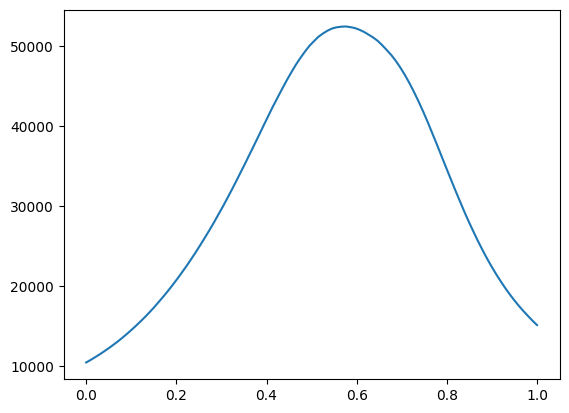

In [142]:
plt.rcdefaults()

plt.plot(np.linspace(0, 1, interpolation_steps), values)

Text(0, 0.5, '|| $W$ ||')

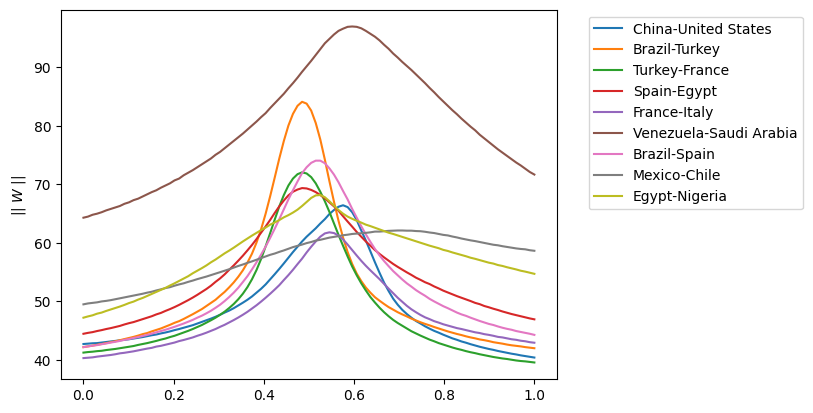

In [26]:
plt.rcdefaults()

for trial, label in zip(W_norms, labels):
    plt.plot(np.linspace(0, 1, interpolation_steps), trial, label=label)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel("|| $W$ ||")

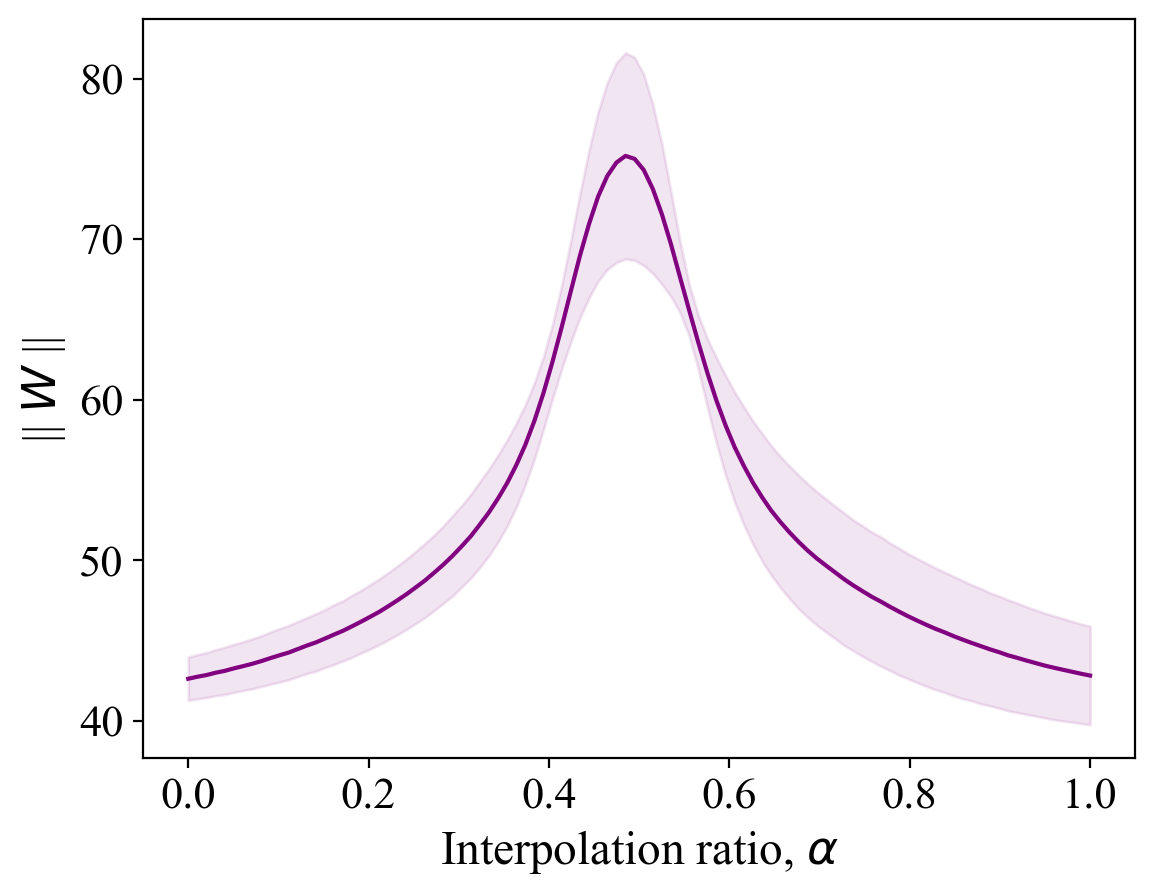

In [28]:
# filter_trials = ["South Korea-Brazil", "Brazil-Nigeria", "Egypt-South Korea", "Chile-Egypt"]
filter_trials = ["Brazil-Turkey", "Turkey-France", "Brazil-France", "Spain-Egypt"]
trial_results = []
for trial, label in zip(W_norms, labels):
    if label not in filter_trials:
        continue
    trial_results.append(trial)
    # plt.plot(np.linspace(0, 1, interpolation_steps), trial, label=label)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

trial_results = np.array(trial_results)
trial_results_mean = trial_results.mean(axis=0)
trial_results_std = trial_results.std(axis=0)


fig_dir = "figures/figs"
#####################################################################################
plt.rcdefaults()
color = "purple"
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", labelsize=MEDIUM_SIZE+1)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=50)  # fontsize of the figure title
#####################################################################################

x = np.linspace(0, 1, interpolation_steps)
plt.plot(x, trial_results_mean, color=color)
plt.fill_between(x, trial_results_mean - trial_results_std, trial_results_mean + trial_results_std, alpha=0.1, color = color)
plt.xlabel("Interpolation ratio, $\\alpha$")
plt.ylabel("|| $W$ ||")

plt.savefig(f"{fig_dir}/j_underestimation.pdf", bbox_inches="tight")

Text(0, 0.5, '|| $W @ \\Delta h$ ||')

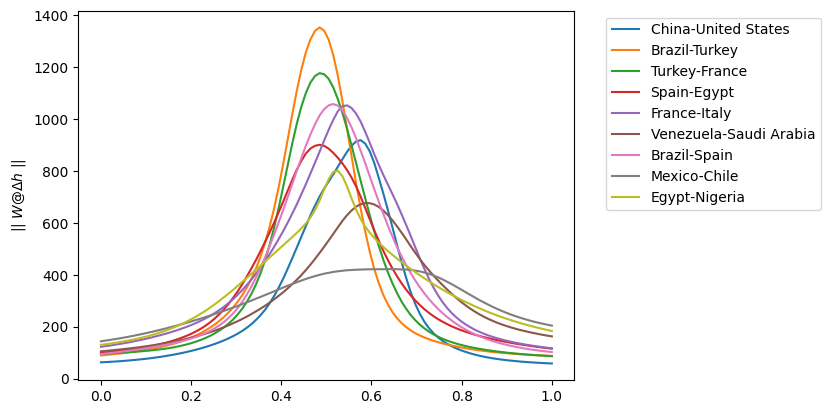

In [29]:
# J(h2 - h1)
plt.rcdefaults()
for trial, label in zip(J_delta_h, labels):
    plt.plot(np.linspace(0, 1, interpolation_steps), trial, label=label)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel("|| $W @ \Delta h$ ||")

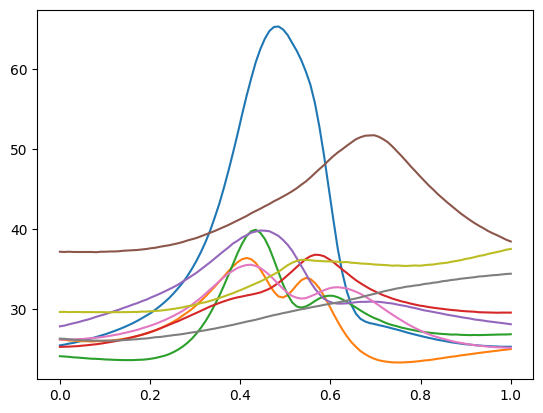

In [30]:
for trial in Jh_norms:
    plt.plot(np.linspace(0, 1, interpolation_steps), trial)